In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
from statistics import mean
from sklearn.preprocessing import StandardScaler
from matplotlib import style
style.use("fivethirtyeight")

# Principal Component Analysis

## Autor: Plamen Vasilev

### Abstract

Whenever you are handling data, you will always face relative features. Those latter are the variables we take into account to describe our data. Namely, if you are collecting some data about houses in Milan, typical features might be position, dimension, floor and so on.

However, it often happens that your data are presented to you provided with many features, sometimes hundreds of them….but do you need all of them? Well, keeping in mind the law of parsimony, we’d rather handle a dataset with few features: it will be far easier and faster to train. On the other hand, we do not want to lose important information while getting rid of some features.

How can we handle this trade-off between simplicity and amount of information? The answer to this question is the result of the **Principal Components Analysis (PCA)**.

### Content
1. Introduction
2. Load data
3. Standardization of the data
4. Construct the covariance matrix
5. Decompose the covariance matrix into its eigenvectors and eigenvalues.
6. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
7. Explained variance - select k eigenvectors which correspond to the k largest eigenvalues, where k is the dimensionality of the new feature subspace (k ≤ d).
8. Projection Matrix - Construct a projection matrix W from the “top” k eigenvectors
9. Transform the d-dimensional input dataset X using the projection matrix W to obtain the new k-dimensional feature subspace
10. PCA implementation
11. PCA application example
12. Conclusion
13. References


## 1. Introduction

**Principal Component Analysis (PCA)** is an unsupervised linear transformation technique that is widely used across different fields, most prominently for feature extraction and dimensionality reduction. Other popular applications of PCA include exploratory data analyses and de-noising of signals in stock market trading, and the analysis of genome data and gene expression levels in the field of bioinformatics.

PCA helps us to identify patterns in data based on the correlation between features. In a nutshell, PCA aims to find the directions of maximum variance in high-dimensional data and projects it onto a new subspace with equal or fewer dimensions than the original one.

The orthogonal axes (**principal components**) of the new subspace can be interpreted as the directions of maximum variance given the constraint that the new feature axes are orthogonal to each other, as illustrated in the following figure:

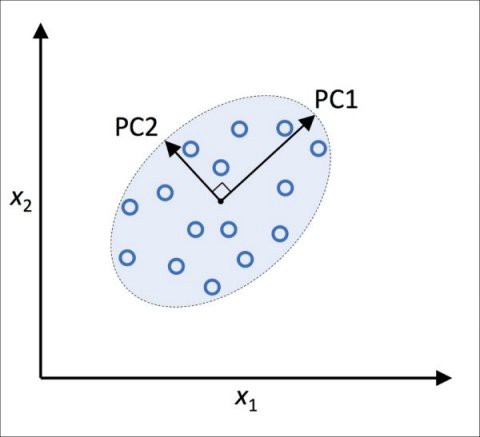
In the preceding figure, x1 and x2 are the original feature axes, and **PC1** and **PC2** are the principal components.

If we use PCA for dimensionality reduction, we construct a **d x k–dimensional transformation matrix W** that allows us to map a sample vector **x** onto a new k–dimensional feature subspace that has fewer dimensions than the original d–dimensional feature space:


$$ \boldsymbol{x} = [x_1,x_2,...,x_d], \boldsymbol{x} \in \mathbb{R}^d $$
$$ \downarrow \boldsymbol{x} W, W \in \mathbb{R}^{dxk} $$
$$ \boldsymbol{z} = [z_1,z_2,...,z_k], \boldsymbol{z} \in \mathbb{R}^k $$

As a result of transforming the original d-dimensional data onto this new k-dimensional subspace (typically k ≪ d), the first principal component will have the largest possible variance, and all consequent principal components will have the largest variance given the constraint that these components are uncorrelated (orthogonal) to the other principal components — even if the input features are correlated, the resulting principal components will be mutually orthogonal (uncorrelated).

Note that the PCA directions are highly sensitive to data scaling, and we need to standardize the features prior to PCA if the features were measured on different scales and we want to assign equal importance to all features.


## 2. Load data

Before we do anything we must load our data.

Data is taken from UC Irvine Machine Learning Repository.

Data Set Information:

This is perhaps the best known database to be found in the pattern recognition literature. Fisher's paper is a classic in the field and is referenced frequently to this day. (See Duda & Hart, for example.) The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the other 2; the latter are NOT linearly separable from each other.

Predicted attribute: class of iris plant.

This is an exceedingly simple domain.

This data differs from the data presented in Fishers article (identified by Steve Chadwick, spchadwick '@' espeedaz.net ). The 35th sample should be: 4.9,3.1,1.5,0.2,"Iris-setosa" where the error is in the fourth feature. The 38th sample: 4.9,3.6,1.4,0.1,"Iris-setosa" where the errors are in the second and third features.


Attribute Information:

1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class:
-- Iris Setosa
-- Iris Versicolour
-- Iris Virginica

![alt text](iris.png)

Here is how it looks our data frame.

In [3]:
data_frame = pd.read_csv(
    filepath_or_buffer='iris.data',
    header=None,
    sep=',')

data_frame.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
data_frame.dropna(how="all", inplace=True) # drops the empty line at file-end

data_frame.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica




## 3. Standardization of the data

The aim of this step is to standardize the range of the continuous initial variables so that each one of them contributes equally to the analysis.

More specifically, the reason why it is critical to perform standardization prior to PCA, is that the latter is quite sensitive regarding the variances of the initial variables. That is, if there are large differences between the ranges of initial variables, those variables with larger ranges will dominate over those with small ranges (For example, a variable that ranges between 0 and 100 will dominate over a variable that ranges between 0 and 1), which will lead to biased results. So, transforming the data to comparable scales can prevent this problem.

This can be done by subtracting the mean and dividing by the standard deviation for each value of each variable (**z**). 
$$ \boldsymbol{z} = \frac{value - mean} {standart  diviation} $$

Mathematically, it looks like this:

$$  \boldsymbol{\sigma} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2} $$
$ \sigma $ - standart diviation;
$ x_i $ - current element;
$ \mu $ - mean

###### Lets see how is done using code:

In [4]:
# split data table into class_values and class_labels

class_values = data_frame.iloc[:,0:4].values
class_labels = data_frame.iloc[:,4].values

Our iris dataset is now stored in form of a **150×4** matrix where the columns are the different features, and every row represents a separate flower sample. Each sample row **x** can be pictured as a 4-dimensional vector

$$ X^T = \begin{pmatrix}x_1\\x_2\\x_3\\x_4\end{pmatrix} = \begin{pmatrix}sepal \ length\\sepal \ width\\petal  \ length\\petal \ width\end{pmatrix} $$

#### Exploratory Visualization
To get a feeling for how the 3 different flower classes are distributes along the 4 different features, let us visualize them via histograms.

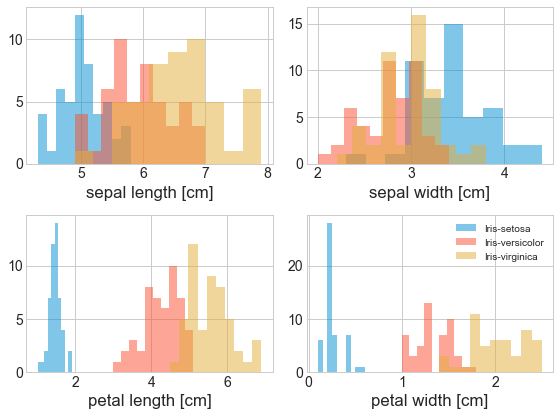

In [5]:
label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for feature in range(len(feature_dict)):
        plt.subplot(2, 2, feature+1)
        for label in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(class_values[class_labels==label, feature],
                     label=label,
                     bins=10,
                     alpha=0.5,)
        plt.xlabel(feature_dict[feature])
    plt.legend(loc='upper right', fancybox=True, fontsize=10)

    plt.tight_layout()
    plt.show()

By the graphs we can get the feeling that Iris-setosa is somehow more distinct to the Iris-Versicolor and Iris-Virginica which seam to me more correlated.

But this is just a feeling we have make the analysis to actually know it.

Let us move to our next step.

####  Standardizing
Whether to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales.

In the plot below we see the results of standardization:

* First the center of the data set is calculated, using the average values of sepal length and sepal width.
* Then the data is shifted to second graph with origin(0, 0), this origin is the at the same position relative to the data from the first graph.
* Finaly all the points are moved from first to the second graph, but they keep their position relative to each other.

For the plot we just use first 2 variables from our data, so we can see it in 2D it is done just for **visual demonstration**.

In [21]:
# for Standardizing we will use sklearn.preprocessing
class_values_standardized = StandardScaler().fit_transform(class_values)

def plot_center_of_data_2D(arr1, arr2, plot_title):
    with plt.style.context('seaborn-whitegrid'):
        plt.scatter(arr1,arr2)
        x_average = mean(arr1)
        y_average = mean(arr2)
        plt.scatter(x_average,y_average, c = 'red')
        plt.title(plot_title)
        plt.xlabel('sepal length')
        plt.ylabel('sepal width')
        plt.show()

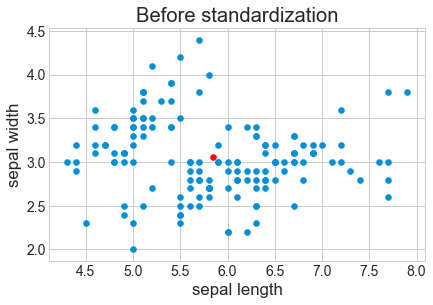

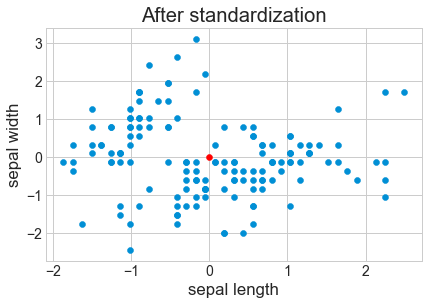

In [22]:
plot_center_of_data_2D(class_values.T[0],class_values.T[1], 'Before standardization')
plot_center_of_data_2D(class_values_standardized.T[0],class_values_standardized.T[1], 'After standardization')

After we have the standardized data our next goal is to construct the covariance matrix

## 4. Construct the covariance matrix

The goal here is to understand how the variables of the input data set are varying from the mean with respect to each other, or in other words, to see if there is any relationship between them. Because sometimes, variables are highly correlated in such a way that they contain redundant information. So, in order to identify these correlations, we compute the covariance matrix.

The covariance matrix is a p × p symmetric matrix (where p is the number of dimensions) that has as entries the covariances associated with all possible pairs of the initial variables. For example, for a 3-dimensional data set with 3 variables x, y, and z, the covariance matrix is a 3×3 matrix of this from:

$$ \begin{pmatrix}Cov(x,x) \ Cov(x,y) \ Cov(x,z)\\
                  Cov(y,x) \ Cov(y,y) \ Cov(y,z)\\
                  Cov(z,x) \ Cov(z,y) \ Cov(z,z)
\end{pmatrix} $$

Since the covariance of a variable with itself is its variance (Cov(a,a)=Var(a)), in the main diagonal (Top left to bottom right) we actually have the variances of each initial variable. And since the covariance is commutative (Cov(a,b)=Cov(b,a)), the entries of the covariance matrix are symmetric with respect to the main diagonal, which means that the upper and the lower triangular portions are equal.

What do the covariances that we have as entries of the matrix tell us about the correlations between the variables?

* if positive then : the two variables increase or decrease together (correlated)
* if negative then : One increases when the other decreases (Inversely correlated)

So, the **covariance matrix** is not more than a table that summaries the correlations between all the possible pairs of variables.

The sample covariances among **K** variables based on **N** observations of each, drawn from an otherwise unobserved population, are given by the **K x K** matrix $ \bar{\boldsymbol{\sigma}} = [\boldsymbol{\sigma}_{jk}] $ with the entries 
$$  \boldsymbol{\sigma}_{jk} = \frac{1}{n-1} \sum_{i=1}^{n} (x_{ij} - \bar{x}_i)(x_{ik} - \bar{x}_k)  $$
which is an estimate of the covariance between variable **j** and variable **k**.

We can summarize the calculation of the covariance matrix via the following matrix equation:
$$ \sum =  \frac{1}{n-1} (X - \bar{x})^T(X - \bar{x})  $$
Where $ \bar{x} $ is the mean vector $$ \bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i $$
The **mean vector** is a d-dimensional vector where each value in this vector represents the sample mean of a feature column in the dataset.

We know from matrix algebra that the rank of a matrix cannot be greater than min(p,n) and, as a consequence, that the number of principal components is also limited to min(p,n). This means that for data sets with more samples than variables the number of calculations is unnessarily high as **n** - **P** principal components have to have zero eigenvalues.

In order to speed up the calculation of the principal components we can transpose the data matrix before performing the principal component analysis. The covariance matrix of the transposed matrix is much smaller and thus faster to process.

**p** - number of variables of the original matrix

**n** - number of samples of the original matrix

###### Lets see how is done using code:

In [8]:
mean_vector = np.mean(class_values_standardized, axis=0)
covariance_matrix = (class_values_standardized - mean_vector).T.dot((class_values_standardized - mean_vector)) / (class_values_standardized.shape[0]-1)
print('Covariance matrix \n%s' %covariance_matrix)

Covariance matrix 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


In [9]:
# The more verbose way above was simply used for demonstration purposes, 
# equivalently, we could have used the numpy cov function:
cov_mat = np.cov(class_values_standardized.T)
print(cov_mat)

[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


## 5. Decompose the covariance matrix into its eigenvectors and eigenvalues.

Before we decompose the covariance matrix let us see what eigenvectors and eigenvalues are...

#### Eigenvectors and eigenvalues

An eigenvector is a vector whose direction remains unchanged when a linear transformation is applied to it. Consider the image below in which three vectors are shown. The green square is only drawn to illustrate the linear transformation that is applied to each of these three vectors.

![alt text](eigenvectors.png)
<center> Eigenvectors (red) do not change direction when a linear transformation (e.g. scaling) is applied to them. Other vectors (yellow) do.</center>

The transformation in this case is a simple scaling with factor 2 in the horizontal direction and factor 0.5 in the vertical direction, such that the transformation matrix A is defined as:

$$ A=\begin{bmatrix} 2 & 0 \\ 0 & 0.5 \end{bmatrix}. $$

A vector $ \vec{v}=(x,y) $ is then scaled by applying this transformation as $ \vec{v}\prime = A\vec{v} $. The above figure shows that the direction of some vectors (shown in red) is not affected by this linear transformation. These vectors are called eigenvectors of the transformation, and uniquely define the square matrix $ A $. This unique, deterministic relation is exactly the reason that those vectors are called ‘eigenvectors’ (Eigen means ‘specific’ in German).

In general, the eigenvector $ \vec{v} $ of a matrix $ A $ is the vector for which the following holds:

$$ \begin{equation*} A \vec{v} = \lambda \vec{v} \end{equation*} $$

where $ \lambda $ is a scalar value called the **eigenvalue**. This means that the linear transformation $ A $ on vector $ \vec{v} $ is completely defined by  $ \lambda $.

#### Calculating the eigenvalues
To determine the eigenvalues for the example we will use this matrix: 
$ \begin{equation*} A = \begin{bmatrix} 2 & 3 \\ 2 & 1 \end{bmatrix}. \end{equation*} $

Calculating the determinant gives:
$$ \begin{equation*} Det\begin{pmatrix}2-\lambda&3\\2&1-\lambda\end{pmatrix}=0. \end{equation*} $$

$$ \begin{align*} &(2-\lambda)(1-\lambda) - 6 = 0\\ \Rightarrow &2 - 2 \lambda - \lambda - \lambda^2 -6 = 0\\ \Rightarrow &{\lambda}^2 - 3 \lambda -4 = 0. \end{align*} $$

To solve this quadratic equation in \lambda, we find the discriminant:

$$  \begin{equation*} D = b^2 -4ac = (-3)^2 -4*1*(-4) = 9+16 = 25. \end{equation*} $$

Since the discriminant is strictly positive, this means that two different values for $ \lambda $ exist:

$$ \begin{align*}  \lambda _1 &= \frac{-b - \sqrt{D}}{2a} = \frac{3-5}{2} = -1,\\ \lambda _2 &= \frac{-b + \sqrt{D}}{2a} = \frac{3+5}{2} = 4. \end{align*}$$
 
We have now determined the two eigenvalues $ \lambda_1 $ and $ \lambda_2 $. Note that a square matrix of size $ N  \times N $ always has exactly $ N $ eigenvalues, each with a corresponding eigenvector. The eigenvalue specifies the size of the eigenvector.

#### Calculating the eigenvectors 
The number of Eigenvectors is determen by the size of a matrix in our case (2 x 2) so **2**.

##### Calculating the first eigenvector
We can now determine the eigenvectors by plugging the eigenvalues have. 
The eigenvectors are then found by solving this system of equations.

We first do this for eigenvalue $ \lambda_1 $, in order to find the corresponding first eigenvector:

$$  \begin{equation*} \begin{bmatrix}2&3\\2&1\end{bmatrix} \begin{bmatrix}x_{11}\\x_{12}\end{bmatrix} = -1   \begin{bmatrix}x_{11}\\x_{12}\end{bmatrix}. \end{equation*} $$

Since this is simply the matrix notation for a system of equations, we can write it in its equivalent form:

 $$ \begin{eqnarray*} \left\{ \begin{array}{lr} 2x_{11} + 3x_{12} = -x_{11}\\ 2x_{11} + x_{12} = -x_{12} \end{array} \right. \end{eqnarray*} $$

and solve the first equation as a function of $ x_{12} $, resulting in:

 $$ \begin{equation*}  x_{11} = -x_{12}. \end{equation*} $$

Since an eigenvector simply represents an orientation (the corresponding eigenvalue represents the magnitude), all scalar multiples of the eigenvector are vectors that are parallel to this eigenvector, and are therefore equivalent (If we would normalize the vectors, they would all be equal). Thus, instead of further solving the above system of equations, we can freely chose a real value for either $ x_{11} $  or $ x_{12} $, and determine the other one by using equation.

For this example, we arbitrarily choose $ x_{12} = 1 $, such that $ x_{11}=-1 $. Therefore, the eigenvector that corresponds to eigenvalue $ \lambda_1 = -1 $ is

 $$ \begin{equation*} \vec{v}_1 = \begin{bmatrix} -1 \\ 1 \end{bmatrix}. \end{equation*} $$

##### Calculating the second eigenvector
Calculations for the second eigenvector are similar to those needed for the first eigenvector;
We now substitute eigenvalue $ \lambda_2=4 $ into equation (1), yielding:

 $$ \begin{equation*} \begin{bmatrix}2&3\\2&1\end{bmatrix} \begin{bmatrix}x_{21}\\x_{22}\end{bmatrix} = 4 * \begin{bmatrix}x_{21}\\x_{22}\end{bmatrix}. \end{equation*} $$

Written as a system of equations, this is equivalent to:

 $$ \begin{eqnarray*} \left\{ \begin{array}{lr} 2x_{21} + 3x_{22} = 4x_{21}\\ 2x_{21} + x_{22} = 4x_{22} \end{array} \right. \end{eqnarray*} $$

Solving the first equation as a function of $ x_{21} $ resuls in:

 $$ \begin{equation*} x_{22} = \frac{3}{2}x_{21} \end{equation*} $$

We then arbitrarily choose $ x_{21}=2 $, and find $ x_{22}=3 $. Therefore, the eigenvector that corresponds to eigenvalue $ \lambda_2 = 4 $ is

 $$ \begin{equation*} \vec{v}_2 = \begin{bmatrix} 3 \\ 2 \end{bmatrix}. \end{equation*} $$
 
 ###### Lets see how is done using code and our data:

In [10]:
# We perform an eigendecomposition on the covariance matrix:
# with numpy is just one lane of code...
eig_vals, eig_vecs = np.linalg.eig(covariance_matrix)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.93035378 0.92740362 0.14834223 0.02074601]


After we have our Eigenvectors and Eigenvalues is time to **sort** them.

## 6. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.

In order to decide which eigenvector(s) can dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues: The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped.

In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top $ k $ eigenvectors.

So we will make Eigenpairs. Those are mathematical pair of an eigenvector ($ẕ$), and its associated eigenvalue ($λ$). This is written as ($λ,ẕ$)

In [11]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenpairs in descending order:')
for i in eig_pairs:
    print(i[0],i[1])

Eigenpairs in descending order:
2.9303537755893156 [ 0.52237162 -0.26335492  0.58125401  0.56561105]
0.9274036215173419 [-0.37231836 -0.92555649 -0.02109478 -0.06541577]
0.14834222648164008 [-0.72101681  0.24203288  0.14089226  0.6338014 ]
0.02074601399559599 [ 0.26199559 -0.12413481 -0.80115427  0.52354627]


After sorting the eigenpairs, the next question is “how many **principal components** are we going to choose for our new feature subspace?” A useful measure is the so-called **“explained variance”**.

Beffore we do so let us see what are the **principal components**.

# Principle components

Principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated and most of the information within the initial variables is squeezed or compressed into the first components. So, the idea is 10-dimensional data gives you 10 principal components, but PCA tries to put maximum possible information in the first component, then maximum remaining information in the second and so on, until having something like shown in the scree plot below.

![alt text](Principal_Components.png)

Organizing information in principal components this way, will allow you to reduce dimensionality without losing much information, and this by discarding the components with low information and considering the remaining components as your new variables.

An important thing to realize here is that, the principal components are less interpretable and don’t have any real meaning since they are constructed as linear combinations of the initial variables.

As there are as many principal components as there are variables in the data, principal components are constructed in such a manner that the first principal component accounts for the largest possible variance in the data set. For example, let’s assume that the scatter plot of our data set is as shown below, can we guess the first principal component ? Yes, it’s approximately the line that matches the purple marks because it goes through the origin and it’s the line in which the projection of the points (red dots) is the most spread out. Or mathematically speaking, it’s the line that maximizes the variance (the average of the squared distances from the projected points (red dots) to the origin).

![alt text](Analysis_second_principal.gif)

The second principal component is calculated in the same way, with the condition that it is uncorrelated with (i.e., perpendicular to) the first principal component and that it accounts for the next highest variance.

This continues until a total of p principal components have been calculated, equal to the original number of variables.

**It is eigenvectors and eigenvalues who are behind all the magic explained above, because the eigenvectors of the Covariance matrix are actually the directions of the axes where there is the most variance(most information) and that we call Principal Components. And eigenvalues are simply the coefficients attached to eigenvectors, which give the amount of variance carried in each Principal Component.**

By ranking your eigenvectors in order of their eigenvalues, highest to lowest, you get the principal components in order of significance. So we continue with the **explained variance** to determine how many principal components we will need.

## 7. Explained variance - select k eigenvectors which correspond to the k largest eigenvalues, where k is the dimensionality of the new feature subspace (k ≤ d).

Principal component analysis computes a new set of variables (“principal components”) and expresses the data in terms of these new variables. Considered together, the new variables represent the same amount of information as the original variables, in the sense that we can restore the original data set from the transformed one.

Moreover, the total variance remains the same. However, it is redistributed among the new variables in the most “unequal” way: the first variable not only explains the most variance among the new variables, but the most variance a single variable can possibly explain.

More generally, the first  principal components (where  can be 1, 2, 3 etc.) explain the most variance any  variables can explain, and the last  variables explain the least variance any  variables can explain, under some general restrictions. 

The **explained variance** tells us how much information can be attributed to each of the principal components.

 ###### Lets see how is done using code and our data:

In [12]:
total_variance = sum(eig_vals)
print(total_variance)
explained_variance = [(i / total_variance)*100 for i in sorted(eig_vals, reverse=True)]
print(explained_variance)
cumulative_explained_variance = np.cumsum(explained_variance)
print(cumulative_explained_variance)

4.026845637583894
[72.77045209380132, 23.03052326768065, 3.683831957627394, 0.5151926808906336]
[ 72.77045209  95.80097536  99.48480732 100.        ]


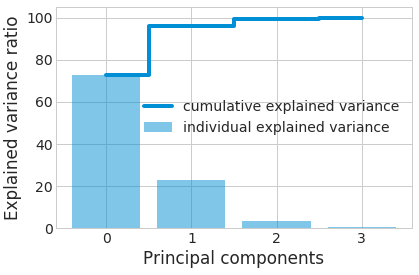

In [13]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cumulative_explained_variance, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

The plot above clearly shows that most of the variance (72.77% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (23.03%) while the third and fourth principal components can safely be dropped without losing to much information. Together, the first two principal components contain 95.8% of the information.

Now it is time to make the **Projection Matrix**.

## 8. Projection Matrix - Construct a projection matrix W from the “top” k eigenvectors

Projection Matrix is basically just a matrix of our concatenated top **k** eigenvectors

The construction of the projection matrix that will be used to transform the Iris data onto the new feature subspace.

Here, we are reducing the 4-dimensional feature space to a 2-dimensional feature subspace, by choosing the **“top 2”**
eigenvectors with the highest eigenvalues to construct our d×k-dimensional eigenvector matrix $ W $.

In [14]:
projection_matrix = np.hstack((eig_pairs[0][1].reshape(4,1),
                      eig_pairs[1][1].reshape(4,1)))

print('Projection Matrix:\n', projection_matrix)

Projection Matrix:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


## 9. Transform the d-dimensional input dataset X using the projection matrix W to obtain the new k-dimensional feature subspace

In this last step we will use the **4×2**-dimensional projection matrix $ W $ to transform our samples onto the new subspace via the equation
$ Y=X×W $, where $ Y $ is a **150×2** matrix of our transformed samples.

In [15]:
print(np.shape(class_values_standardized))
print(np.shape(projection_matrix))
transformed_samples_matrix = class_values_standardized.dot(projection_matrix)
print(np.shape(transformed_samples_matrix))
# print(transformed_samples_matrix)

(150, 4)
(4, 2)
(150, 2)


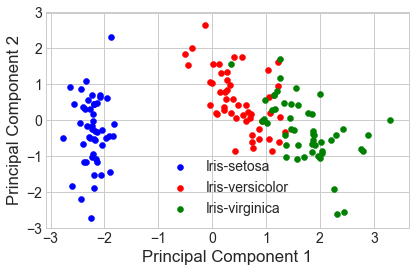

In [16]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for label, color in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'red', 'green')):
        plt.scatter(transformed_samples_matrix[class_labels==label, 0],
                    transformed_samples_matrix[class_labels==label, 1],
                    label=label,
                    color=color)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

Now, what we got after applying the linear PCA transformation is a lower dimensional subspace (from **4D** to **2D** in this case), where the samples are “most spread” along the new feature axes.

In this plot we have identify each species with different color for an easy observation. We can see how the method has separated the different kind of flowers, and how using PCA allow as to identify the data structure.

Now we can really say that our fealing from start seams to be accurate Irid-setosa is a somehow distinguished from the other two plants Irus-versicolor and Iris-virginica seams to be correlated to each other.

## 10.  PCA implementation

All above is realy complicated but in python PCA code looks like this...

##### Lets Implement PCA and make a practilce axample, lets try to see features in a **13D** space, projected in **2D**.

[ 36.1988481   55.40633836  66.52996889  73.59899908  80.16229276
  85.09811607  89.3367954   90.13201029  92.81275924  94.11099181
  96.33314522  98.06998091 100.        ]


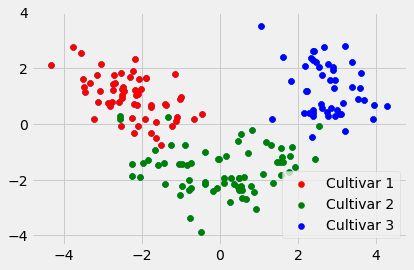

In [17]:
""" Data Set Information:
These data are the results of a chemical analysis of wines grown in the same region in 
Italy but derived from three different cultivars. The analysis determined the 
quantities of 13 constituents found in each of the three types of wines."""

"""1. Collect the data - Data taken from - https://archive.ics.uci.edu/ml/datasets/Wine"""
dataFrame = pd.read_table('wine.data',sep=',',names=['Alcohol','Malic_acid','Ash','Alcalinity of ash',
                                              'Magnesium','Total phenols','Flavanoids','Nonflavanoid_phenols',
                                              'Proanthocyanins','Color_intensity','Hue',
                                                 'OD280/OD315_of_diluted_wines','Proline'])
# print(df)
target = dataFrame.index

"""2. Normalize the data""" 
dataFrame = StandardScaler().fit_transform(dataFrame)

"""3. Calculate the covariance matrix"""        
COV = np.cov(dataFrame.T) 
# We have to transpose the data since the documentation of np.cov() sais 
# Each row of COV represents a variable, and each column a single observation of all those variables 

"""4. Find the eigenvalues and eigenvectors of the covariance matrix""" 
eigval,eigvec = np.linalg.eig(COV)
print(np.cumsum([i*(100/sum(eigval)) for i in eigval])) 
# As you can see, the first two principal components contain 55% of the total variation while the first 8 PC contain 90%


"""5. Use the principal components to transform the data - Reduce the dimensionality of the data"""
# The wine dataset is 13 dimensional and we want to reduce the dimensionality to 2 dimensions 
# Therefore we use the two eigenvectors with the two largest eigenvalues and use this vectors 
#    to transform the original dataset.
# We want to have 2 Dimensions hence the resulting dataset should be a 178x2 matrix.
# The original dataset is a 178x13 matrix and hence the "principal component matrix" must be of 
# shape 13*2 where the 2 columns contain the covariance eigenvectors with the two largest eigenvalues

PC = eigvec.T[0:2]
# print(np.shape(df))
# print(np.shape(PC.T))
data_transformed = np.dot(dataFrame,PC.T) # We have to transpose PC because it is of the format 2x178
# print(data_transformed)

# Plot the data
fig = plt.figure(figsize=(6,4))
subplot = fig.add_subplot(111)

subplot.scatter(data_transformed.T[0],data_transformed.T[1])
# print(np.unique(target))
for label, color in zip((np.unique(target)),['red','green','blue']):
     subplot.scatter(data_transformed.T[0,target==label],
                     data_transformed.T[1,target==label],
                     color=color,
                     label="Cultivar " + str(label))
subplot.legend()
plt.show()


As you can see, the 13 dimensional dataset has been reduced to a 2 dimensional dataset which still entails 55% of the total variation and which we now can plot into a two dimensional coordinate system. Mind that normally we do not have the target feature values of a dataset since the PCA is an unsupervised learning algorithm. Though, we have included the target feature values here to show that the dataset is still very well separable with only two dimensions. So what we have done above is that we have kind of created new features from the other features by transforming the dataset using the principal components of the dataset and therewith reduced the dimensionality of the dataset (the remaining columns of our transformed dataset serve as new features) without loosing too much information.

We can can that results of the wine of Cultivar 1 are different to those of Cultivar 3, but their results are close to Cultiver 2's, even tho they differ a bit also. 

## 11. PCA application example

#### Image compression

In this example, PCA is applied in the compression of 512-by-512 grey-scale image (Figure 1). The image is represented by a matrix X∈R512×512. According to the procedure described in Technical procedure section, principal component directions V∈R512×512 is extracted from covariance of the matrix X. 

![alt text](Ex_2_original.png)
<center> Figure 1. Original greyscale image. </center>

Figure 2 depicts the first 30 eigenvalues. By only looking at the eigenvalues, it is hard to judge how many principal components are required to effectively represent the original image without loss of generality. 

![alt text](Ex_2_eigs.png)
<center> Figure 2. Ordered eigenvalues. </center>

As given in Figure 3-(b), even though the first five principal components show relatively large eigenvalues (Figure 2), the projected image does not provide clear correspondence to the original image. Figure 3 shows projection of the original image on new image space defined by different number of principal components. As the number of principal components increases, the projected image becomes visually close to the original image.

![alt text](Ex_2_pics.png)
<center> Figure 3. PCA results </center>

From the pictures of Figure 3 we can say that the number of principal components we need is not fixed, it is based on the task we are assigned with or is needed to get the task done.

## 12. Conclusion

Although PCA in its standard form is a widely used and adaptive descriptive data analysis tool, it also has many adaptations of its own that make it useful to a wide variety of situations and data types in numerous disciplines. Adaptations of PCA have been proposed, among others, for binary data, ordinal data, compositional data, discrete data, symbolic data or data with special structure, such as time series or datasets with common covariance matrices. PCA or PCA-related approaches have also played an important direct role in other statistical methods, such as linear regression (with principal component regression ) and even simultaneous clustering of both individuals and variables . Methods such as correspondance analysis, canonical correlation analysis or linear discriminant analysis may be only loosely connected to PCA, but, insofar as they are based on factorial decompositions of certain matrices, they share a common approach with PCA. The literature on PCA is vast and spans many disciplines. Space constraints mean that it has been explored very superficially here. New adaptations and methodological results, as well as applications, are still appearing.

## 13. References

* Wikipedia - Eigenvalues and eigenvectors - https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors
* Wikipedia - Principal component analysis - https://en.wikipedia.org/wiki/Principal_component_analysis#History
* Principal component analysis: a review and recent developments - Ian T. Jolliffe and Jorge Cadima Published:13 April 2016 - https://royalsocietypublishing.org/doi/10.1098/rsta.2015.0202
* Wikipedia - Spectrum of a matrix - https://en.wikipedia.org/wiki/Spectrum_of_a_matrix
* Showing that an eigenbasis makes for good coordinate systems - https://www.khanacademy.org/math/linear-algebra/alternate-bases/eigen-everything/v/linear-algebra-showing-that-an-eigenbasis-makes-for-good-coordinate-systems
* Principal Component Analysis in 3 Simple Steps Jan 27, 2015 by Sebastian Raschka - http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html#covariance-matrix
* A STEP BY STEP EXPLANATION OF PRINCIPAL COMPONENT ANALYSIS Zakaria Jaadi September 4, 2019 Updated: February 24, 2020 - https://builtin.com/data-science/step-step-explanation-principal-component-analysis
* Machine Learning Unsupervised Learning Dimensionality Reduction Principal Component Analysis (PCA) - https://www.python-course.eu/principal_component_analysis.php
* PCA: Eigenvectors and Eigenvalues Valentina Alto Jul 13, 2019 · 6 min read - https://towardsdatascience.com/pca-eigenvectors-and-eigenvalues-1f968bc6777a
* Principal Component Analysis for Dimensionality Reduction lgorithm and executing it step-by-step with Python! Lorraine Li May 25, 2019 - https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad
* 6.5.4.1. Mean Vector and Covariance Matrix - Engineering statistic handbook - https://www.itl.nist.gov/div898/handbook/pmc/section5/pmc541.htm
* Standard Deviation Formulas - https://www.mathsisfun.com/data/standard-deviation-formulas.html
* What are eigenvectors and eigenvalues? - https://www.visiondummy.com/2014/03/eigenvalues-eigenvectors/#id3583665669
* Roman Cheplyaka Explained variance in PCA Published on December 11, 2017 - https://ro-che.info/articles/2017-12-11-pca-explained-variance
* Basics and Examples of Principal Component Analysis (PCA) - https://www.projectrhea.org/rhea/index.php/PCA_Theory_Examples
* Principal component analysis: a review and recent developments Ian T. Jolliffe1 and Jorge Cadima - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4792409/
* Center for Machine Learning and Intelligent Systems - https://archive.ics.uci.edu/ml/datasets.php


